In [1]:
import pydicom as dicom
import matplotlib.pylab as plt
import numpy as np
import os
import skimage as ski
from skimage.transform import warp, AffineTransform, pyramid_expand, pyramid_reduce
import cv2
import scipy
from skimage.filters import unsharp_mask
from natsort import natsorted
from skimage.exposure import match_histograms
# from sklearn.mixture import GaussianMixture
from skimage.registration import phase_cross_correlation
from scipy import ndimage as scp
from tqdm import tqdm
from skimage.metrics import normalized_root_mse as nrm
# from statsmodels.tsa.stattools import acf
import pickle
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA
from scipy.fftpack import fft2, fftshift, ifft2, fft, ifft
import time
import math
from skimage.exposure import equalize_hist
from skimage.exposure import equalize_adapthist
# from skimage.feature import SIFT, match_descriptors,plot_matches
# from skimage.feature import ORB
import ants.registration as ants_register
import ants
from scipy.optimize import minimize as minz
from scipy.optimize import dual_annealing,fmin_powell
from scipy import optimize
import pickle
from skimage.filters import threshold_otsu
from skimage.metrics import normalized_mutual_information as nmi
from skimage.metrics import mean_squared_error as mse
from tifffile import imread as tiffread
import sys
from util_funcs import *
import h5py

In [2]:
path = f'scan5/'
# path = 'intervolume_registered/self_inter/scan5/'
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.h5'):
        pic_paths.append(i)
with h5py.File(path+pic_paths[0], 'r') as hf:
    original_data = np.array(hf['volume'])

# original_data = original_data[:,200:,:]

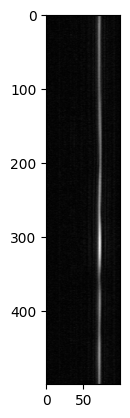

In [5]:
plt.imshow(original_data[:,:,10][:,1100:1200],cmap='gray')

In [72]:
# plt.imshow(original_data[:,970,:],cmap='gray')
# plt.savefig('pre_registration_enface.PNG',dpi=500)

In [73]:
# 264,1172-200

In [74]:
# original_data = original_data[:,200:,:]

In [6]:

def ants_all_trans(data,UP,DOWN):
    transforms_all = np.tile(np.eye(3),(data.shape[0],1,1))
    for i in tqdm(range(data.shape[0]-1),desc='tr_all'):
        temp_img = data[i+1][UP:DOWN][:,-50:].copy()
        stat = data[i][UP:DOWN][:,-50:].copy()
        # PHASE
        coords = phase_cross_correlation((stat)
                                        ,(temp_img)
                                        ,normalization=None,upsample_factor=20)[0]
        if np.abs(coords[0])<=5:
            temp_img = warp(temp_img,AffineTransform(translation = (0,-coords[0])),order=3)
            tff = AffineTransform(translation = (0,-coords[0]))
            transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)

        # MANUAL
        temp_tform_manual = AffineTransform(translation=(0,0))
        temp_manual = temp_img.copy()
        past_shift = 0
        for _ in range(5):
            move = minz(method='powell',fun = mse_fun_tran,x0 =(0), bounds=[(-5,5)],
                        args = (stat
                                ,temp_manual
                                ,past_shift))['x']
            temp_transform = AffineTransform(translation=(0,move[0]))
            past_shift += move[0]
            # temp_manual = warp(temp_manual, temp_transform,order=3)
            temp_tform_manual = np.dot(temp_tform_manual,temp_transform)
        temp_tform_manual = AffineTransform(matrix = temp_tform_manual)
        # if np.abs(np.array(temp_tform_manual)[1,2])<=2:
        #     temp_img = warp(temp_img,temp_tform_manual,order=3)
        transforms_all[i+1:] = np.dot(transforms_all[i+1:],temp_tform_manual)

    return transforms_all

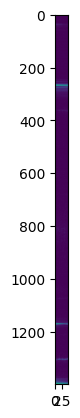

In [7]:
# plt.imshow(original_data[-100:,1172-200,250:320])
plt.imshow(original_data[0][:,-50:])

In [8]:
# nn = [np.argmax(np.sum(original_data[i][n//2:1000],axis=1)) for i in range(original_data.shape[0])]
# UP, DOWN = np.min(nn)-50,np.max(nn)+50
# UP = UP if UP>0 else 0
# DOWN = DOWN if DOWN<(1000-n//2) else (1000-n//2) 
# UP,DOWN = UP+n//2,DOWN+n//2

# print(UP,DOWN)

In [9]:
mid = find_mid(original_data)
n = original_data.shape[1]

# finding the bright points in all images in standard interference
nn = [np.argmax(np.sum(original_data[i][:n//2],axis=1)) for i in range(original_data.shape[0])]

# intial correcting the y-motion
tf_all_nn = np.tile(np.eye(3),(original_data.shape[0],1,1))
for i in range(tf_all_nn.shape[0]):
    tf_all_nn[i] = np.dot(tf_all_nn[i],AffineTransform(translation=(0,-(nn[0]-nn[i]))))
for i in tqdm(range(original_data.shape[0]),desc='warping'):
    original_data[i][:mid]  = warp(original_data[i][:mid],AffineTransform(matrix=tf_all_nn[i]),order=3)

# finding the bright points in all images to crop the standard interference
nn = [np.argmax(np.sum(original_data[i][:n//2],axis=1)) for i in range(original_data.shape[0])]
UP, DOWN = np.min(nn)-80,np.max(nn)+80
UP = UP if UP>0 else 0
DOWN = DOWN if DOWN<original_data.shape[1] else original_data.shape[1]

print(UP,DOWN)

warping: 100%|██████████| 500/500 [00:11<00:00, 42.64it/s]


188 348


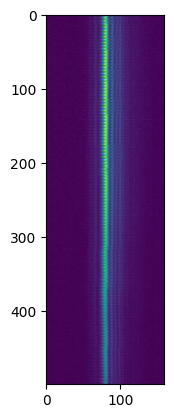

In [11]:
plt.imshow(original_data[:,UP:DOWN,:][:,:,400])

In [12]:
# better correcting the y-motion using functions
tr_all = ants_all_trans(original_data,UP,DOWN) # fucntion definition in util_funcs.py
for i in tqdm(range(original_data.shape[0]),desc='warping'):
    original_data[i][:mid]  = warp(original_data[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:10<00:00, 45.71it/s]


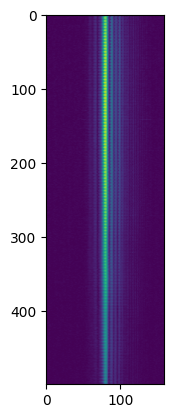

In [13]:
plt.imshow(original_data[:,UP:DOWN,:][:,:,400])

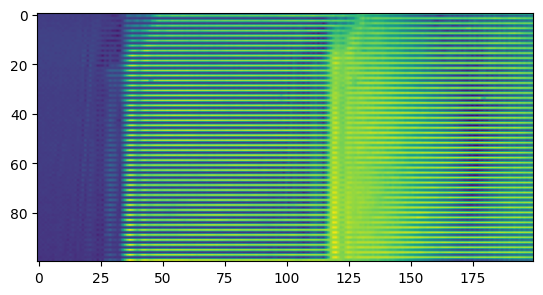

In [237]:
# temp_img = original_data[:,1172-200,270:320].copy()
temp_img = original_data[:,1172,250:450].copy()

# tp = fft2(temp_img).flatten()
# tp[tp.shape[0]//2:] = 0
# # tp = np.where(np.abs(tp)>7.7,tp,0)
# temp_img = ifft2(tp.reshape(temp_img.shape)).real

plt.imshow(temp_img[:100])

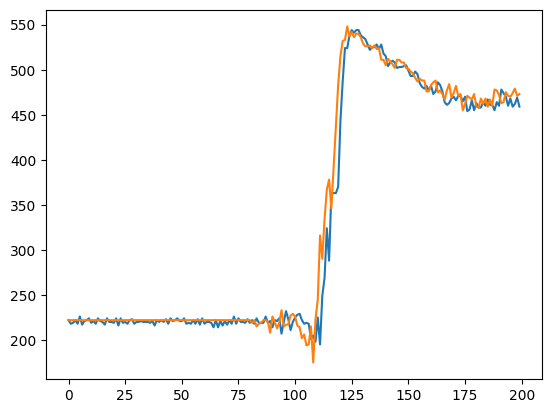

In [238]:
plt.plot(temp_img[302])
# plt.plot(denoise_signal(match_histograms(temp_img[340],temp_img[302]),rows=20))
plt.plot(scp.shift(temp_img[303],80,mode='nearest'))

In [239]:
def shift_func(shif, x, y , past_shift):
    x = scp.shift(x, -past_shift,order=3,mode='nearest')
    y = scp.shift(y, past_shift,order=3,mode='nearest')

    warped_x_stat = scp.shift(x, -shif[0],order=3,mode='nearest')
    warped_y_mov = scp.shift(y, shif[0],order=3,mode='nearest')

    return (1-ncc1d(warped_x_stat ,warped_y_mov))

# def denoise_signal(errs , rows = 10):
#     kk = fft(errs)
#     kk[rows:] = 0
#     kk = abs(ifft(kk))
#     return kk

In [249]:
temp_img = original_data[:,1172,250:450].copy()

In [ ]:
kk = []
for i in range(100):
    move = minz(method='powell',fun = shift_func,x0 =(0),bounds = ([(-100,100)]),
                        args = (temp_img[i]
                                ,temp_img[i+1]
                                ,0))['x']
    kk.append(move[0]*2)

init_move = np.median(kk[::2])
for i in range(1,temp_img.shape[0],2):
    temp_img[i] = scp.shift(temp_img[i], init_move,order=3,mode='nearest')

In [251]:
if init_move<0:
    temp_img = temp_img[:,:-int(init_move)]
else:
    temp_img = temp_img[:,int(init_move):]

In [253]:
sf = [0]
for i in tqdm(range(temp_img.shape[0]-1)):
        st = temp_img[i]
        mv = temp_img[i+1]
        rt = 0
        past_shift = 0
        for _ in range(20):
                # move = minz(method='powell',fun = shift_func,x0 =(0),bounds = ([(-100,100)]),
                #         args = (st
                #                 ,mv
                #                 ,past_shift))['x']

                move = minz(method='L-BFGS-B',fun = shift_func,x0 =(0),bounds = ([(-4,4)]),
                        args = (st
                                ,mv
                                ,past_shift))['x']

                past_shift += move[0]/2
                rt+=move[0]/2
        sf.append(rt*2)

100%|██████████| 499/499 [00:21<00:00, 23.16it/s]


In [231]:
# sf = np.array(sf)
# for i in range(1,sf.shape[0]):
#     sf[i] += sf[i-1]

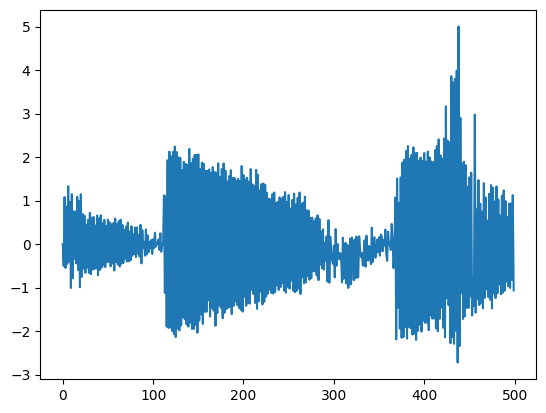

In [254]:
plt.plot(sf)

In [255]:
temp_img = original_data[:,1172,:].copy()
for i in range(1,len(sf),2):
    temp_img[i] = scp.shift(temp_img[i],sf[i]+init_move,order=3)

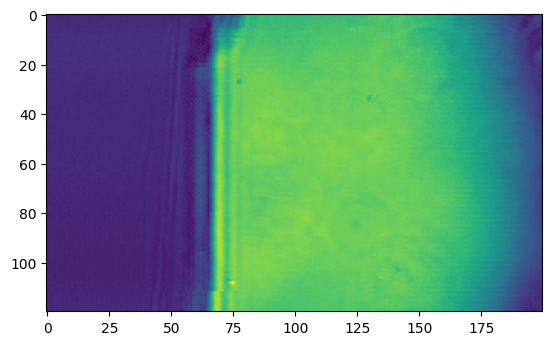

In [259]:
plt.imshow(temp_img[:120,300:])

In [91]:
gg = original_data

In [92]:
for i in tqdm(range(len(sf))):
    # original_data[i] = scp.shift(original_data[i],shift = (0,sf[i]),order=3,mode='nearest')
    gg[i] = warp(gg[i], AffineTransform(translation = (-sf[i],0)))

100%|██████████| 500/500 [00:12<00:00, 38.86it/s]


In [62]:
os.makedirs('test',exist_ok=True)
for i,j in tqdm(enumerate(gg)):
    cv2.imwrite(f'test/'+f'frame_test{i}.PNG',j)

500it [00:03, 165.03it/s]


In [585]:
import time

In [648]:
nn = [np.argmax(np.sum(original_data[i][:n//2],axis=1)) for i in range(original_data.shape[0])]
UP, DOWN = np.min(nn)-50,np.max(nn)+50
UP = UP if UP>0 else 0
DOWN = DOWN if DOWN<original_data.shape[1] else original_data.shape[1]
standard_inter_UP,standard_inter_DOWN = UP,DOWN

nn = [np.argmax(np.sum(original_data[i][n//2:1000],axis=1)) for i in range(original_data.shape[0])]
UP, DOWN = np.min(nn)-50,np.max(nn)+50
UP = UP if UP>0 else 0
DOWN = DOWN if DOWN<(1000-n//2) else (1000-n//2) 
self_inter_UP,self_inter_DOWN = UP+n//2,DOWN+n//2

In [649]:
standard_inter_UP,standard_inter_DOWN,self_inter_UP,self_inter_DOWN

(18, 119, 921, 1000)

In [654]:
(1000-921)/2

39.5

In [650]:
crop = original_data[:,np.r_[standard_inter_UP:standard_inter_DOWN,self_inter_UP:self_inter_DOWN],:]

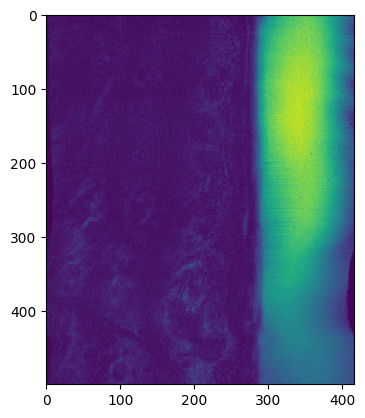

In [656]:
plt.imshow(crop[:,69,:])

62

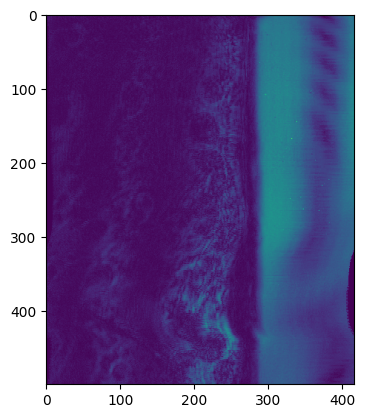

In [674]:
m = crop[:,:,10]
enf_idx = np.argmax(np.sum(m[:,m.shape[1]//2:],axis=0))
plt.imshow(crop[:,enf_idx,:])

In [ ]:
# done_scans = set([i for i in os.listdir('registered') if (i.startswith('scan'))])
# print(done_scans)
# scans = [i for i in os.listdir() if (i.startswith('scan')) and (i not in done_scans)]
# print('REMAINING',scans)
# for sc in scans:
#     print(f'Processing {sc}-----------------------------------------')
#     st = time.perf_counter()
#     run_scans(sc)
#     end = time.perf_counter()-st
#     print(f"Elapsed time: {end:.4f} seconds")
#     print(f'Done Processing {sc}------------------------------------')

In [260]:
import psutil
import gc

In [1]:
gc.collect()
psutil.virtual_memory().percent

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/akapatil/opt/anaconda3/envs/ImageProc_2/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/y0/g6cs3y9d4hlc0g10qn8s1bdc0000gn/T/ipykernel_9444/1306611471.py", line 1, in <module>
    gc.collect()
    ^^
NameError: name 'gc' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/akapatil/opt/anaconda3/envs/ImageProc_2/lib/python3.11/site-packages/pygments/styles/__init__.py", line 45, in get_style_by_name
ModuleNotFoundError: No module named 'pygments.styles.default'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/akapatil/opt/anaconda3/envs/ImageProc_2/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structur

In [264]:
all_scans = natsorted(set([i for i in os.listdir('intervolume_registered/self_inter') if (i.startswith('scan'))]))

In [265]:
all_scans

['scan1',
 'scan2',
 'scan3',
 'scan4',
 'scan5',
 'scan6',
 'scan7',
 'scan8',
 'scan9',
 'scan10',
 'scan11',
 'scan12',
 'scan13',
 'scan14',
 'scan15',
 'scan16',
 'scan17',
 'scan18',
 'scan19',
 'scan20',
 'scan21',
 'scan22',
 'scan23',
 'scan24',
 'scan25',
 'scan26',
 'scan27',
 'scan28',
 'scan29',
 'scan30']

In [286]:
def load_h5_data(scan_num, transform = None):
    # path = f'registered/self_inter/{scan_num}/{scan_num}.h5'
    path = f'intervolume_registered/self_inter/{scan_num}/{scan_num}.h5'
    with h5py.File(path, 'r') as hf:
        data = hf['volume']
    # first_frame = data[10]
        first_frame = 0
        print(psutil.virtual_memory().percent)
        m = data[:,:,100]
        # m = data
        enf_idx = np.argmax(np.sum(m,axis=0))
        enface = data[:,enf_idx,:]
        # del data
        gc.collect()
    return first_frame,enface
    


In [287]:
frames,enfaces = [],[]
for scan_num in all_scans:
    temp1, temp2 = load_h5_data(scan_num)
    # frames.append(temp1)
    enfaces.append(temp2)
    print(scan_num,'DONE')

94.4
scan1 DONE
94.5
scan2 DONE
94.5
scan3 DONE
94.4
scan4 DONE
94.5
scan5 DONE
94.5
scan6 DONE
94.6
scan7 DONE
94.6
scan8 DONE
94.5
scan9 DONE
94.5
scan10 DONE
94.5
scan11 DONE
94.5
scan12 DONE
94.5
scan13 DONE
94.5
scan14 DONE
94.6
scan15 DONE
94.6
scan16 DONE
94.6
scan17 DONE
94.5
scan18 DONE
94.6
scan19 DONE
94.6
scan20 DONE
94.5
scan21 DONE
94.6
scan22 DONE
94.5
scan23 DONE
94.5
scan24 DONE
94.5
scan25 DONE
94.6
scan26 DONE
94.6
scan27 DONE
94.6
scan28 DONE
94.6
scan29 DONE
94.5
scan30 DONE


In [288]:
# frames = np.array(frames)
enfaces = np.array(enfaces)

In [289]:
os.makedirs('test',exist_ok=True)
for i,j in tqdm(enumerate(enfaces)):
    cv2.imwrite(f'test/'+f'frame_test{i}.PNG',j)

30it [00:00, 441.04it/s]


In [765]:
def mse_fun_tran(shif, x, y , past_shift):
    x = warp(x, AffineTransform(translation=(0,-past_shift)),order=3,mode='edge')
    y = warp(y, AffineTransform(translation=(0,past_shift)),order=3,mode='edge')

    warped_x_stat = warp(x, AffineTransform(translation=(0,-shif[0])),order=3,mode='edge')
    warped_y_mov = warp(y, AffineTransform(translation=(0,shif[0])),order=3,mode='edge')

    return (1-ncc(warped_x_stat ,warped_y_mov))

In [766]:
y_intervolume = [0]
for i in tqdm(range(frames.shape[0]-1)):
        st = frames[i]
        mv = frames[i+1]
        rt = 0
        past_shift = 0
        for _ in range(10):
                move = minz(method='powell',fun = mse_fun_tran,x0 =(0),bounds = ([(-3,3)]),
                        args = (st
                                ,mv
                                ,past_shift))['x']
                past_shift += move[0]
                rt+=move[0]
        y_intervolume.append(rt*2)
y_intervolume = np.array(y_intervolume)
for i in range(1,y_intervolume.shape[0]):
    y_intervolume[i] += y_intervolume[i-1]

100%|██████████| 29/29 [01:39<00:00,  3.42s/it]


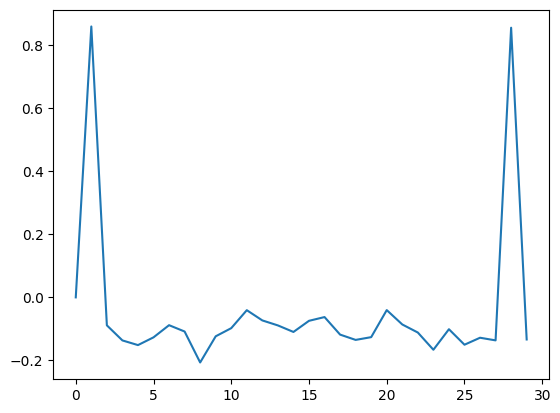

In [767]:
plt.plot(y_intervolume)

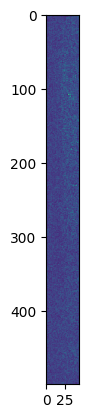

In [18]:
plt.imshow(enfaces[1][:,265:310])

In [780]:
def mse_fun_tran(shif, x, y , past_shift):
    x = warp(x, AffineTransform(translation=(-past_shift,0)),order=3,mode='edge')
    y = warp(y, AffineTransform(translation=(past_shift,0)),order=3,mode='edge')

    warped_x_stat = warp(x, AffineTransform(translation=(-shif[0],0)),order=3,mode='edge')
    warped_y_mov = warp(y, AffineTransform(translation=(shif[0],0)),order=3,mode='edge')

    return (2-nmi(warped_x_stat ,warped_y_mov))

In [781]:
x_intervolume = [0]
for i in tqdm(range(enfaces.shape[0]-1)):
        st = enfaces[i][200:300,265:310]
        mv = enfaces[i+1][200:300,265:310]
        rt = 0
        past_shift = 0
        for _ in range(10):
                move = minz(method='powell',fun = mse_fun_tran,x0 =(0),bounds = ([(-3,3)]),
                        args = (st
                                ,mv
                                ,past_shift))['x']
                past_shift += move[0]
                rt+=move[0]
        x_intervolume.append(rt*2)
x_intervolume = np.array(x_intervolume)
for i in range(1,x_intervolume.shape[0]):
    x_intervolume[i] += x_intervolume[i-1]

100%|██████████| 29/29 [00:35<00:00,  1.23s/it]


In [782]:
temp_e = enfaces.copy()
for i in range(temp_e.shape[0]):
    temp_e[i] = warp(temp_e[i], AffineTransform(translation=(x_intervolume[i],0)),order=3,mode='edge')

In [779]:
os.makedirs('test',exist_ok=True)
for i,j in tqdm(enumerate(enfaces)):
    cv2.imwrite(f'test/'+f'frame_test{i}.PNG',j)

30it [00:00, 398.63it/s]


In [783]:
enfaces.shape

(30, 500, 417)

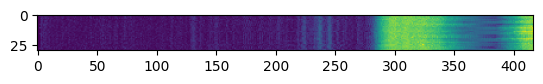

In [784]:
plt.imshow(enfaces[:,10,:])

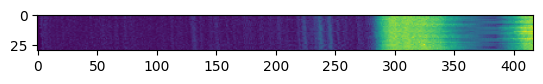

In [785]:
plt.imshow(temp_e[:,10,:])

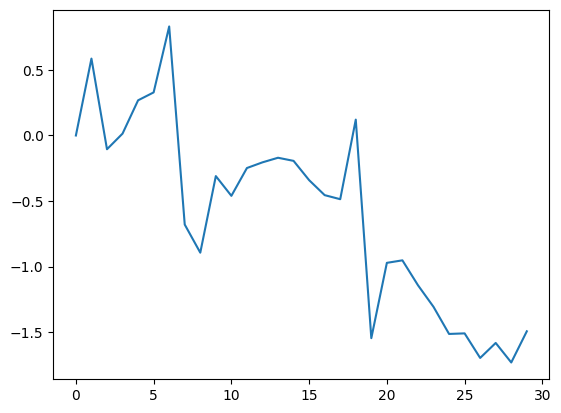

In [756]:
plt.plot(x_intervolume)

# Test

In [2]:
data_path = '/Users/akapatil/Documents/OCT/IR_card_glass_side_3_13_2025/intervolume_registered/self_inter'
def load_h5_data(path_scan):
    path = path_scan
    with h5py.File(path, 'r') as hf:
        data = np.array(hf['volume'])
    return first_frame, enface

def load_nested_data_h5(path):
    pic_paths = []
    for scan_num in natsorted(os.listdir(path)):
        if scan_num.startswith('scan'):
            pic_paths.append(os.path.join(path,scan_num,f'{scan_num}.h5'))

    with h5py.File(pic_paths[0], 'r') as hf:
        b = np.array(hf['volume'])
    data = np.empty((len(pic_paths),b.shape[0],b.shape[1],b.shape[2]))
    for idx,img_path in enumerate(pic_paths):
        with h5py.File(img_path, 'r') as hf:
            temp = np.array(hf['volume'])
        data[idx]=(temp.copy())
    return data

In [4]:
image_list = os.listdir(data_path)#list all images address in data_path
# fourD_image_volume_complete = utils.load_nested_data_pickle(data_path, len(image_list))#load all image volume and combine them in one 4D np array
fourD_image_volume_complete = load_nested_data_h5(data_path)
fourD_image = fourD_image_volume_complete[:20, :, 50, :]

In [6]:
fourD_image_volume_complete.shape

(30, 500, 80, 417)

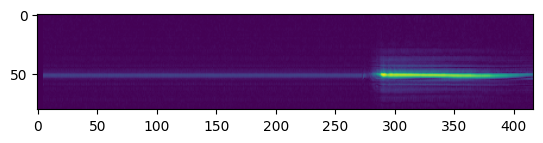

In [7]:
plt.imshow(fourD_image_volume_complete[3,20])

In [924]:
def ncc2d(array1, array2):
    array1_centered = array1 - np.mean(array1)
    array2_centered = array2 - np.mean(array2)
    dot_product = np.sum(array1_centered * array2_centered)
    norm1 = np.linalg.norm(array1_centered)
    norm2 = np.linalg.norm(array2_centered)
    if norm1 == 0 or norm2 == 0:
        return 0
    return dot_product / (norm1 * norm2)

In [925]:
# temp_img = fourD_image.copy()

In [926]:
def shift_func(shif, x, y , past_shift):
    x = scp.shift(x, -past_shift,order=3,mode='nearest')
    y = scp.shift(y, past_shift,order=3,mode='nearest')

    warped_x_stat = scp.shift(x, -shif[0],order=3,mode='nearest')
    warped_y_mov = scp.shift(y, shif[0],order=3,mode='nearest')

    return (1-ncc1d(warped_x_stat ,warped_y_mov))

def denoise_signal(errs , rows = 10):
    kk = fft(errs)
    kk[rows:] = 0
    kk = abs(ifft(kk))
    return kk

In [ ]:
sf_all = []
for i in tqdm(range(fourD_image.shape[0])):
    sf_row = []
    for j in range(fourD_image[0].shape[0]):
        ps = 0
        row_st = fourD_image[15][:,250:350][j].copy()
        row_mv = fourD_image[i][:,250:350][j].copy()
        for _ in range(5):
            result = minz(method='L-BFGS-B', fun=shift_func, x0=0, 
                        bounds= [(-3, 3)], args=(row_st, row_mv, ps))
            ps += result['x']

        sf_row.append(ps * 2)
    sf_all.append(np.array(sf_row))

100%|██████████| 20/20 [01:17<00:00,  3.86s/it]


In [937]:
temp_fD = fourD_image.copy()

In [938]:
sf_all = np.squeeze(sf_all)
for i in range(sf_all.shape[0]):
    for j in range(temp_fD[i].shape[0]):
        temp_fD[i,j] = scp.shift(temp_fD[i,j], sf_all[i,j],order=3,mode='nearest')

In [1]:
plt.plot(sf_all[0])

NameError: name 'plt' is not defined

In [941]:
os.makedirs('test',exist_ok=True)
for i,j in tqdm(enumerate(temp_fD)):
    cv2.imwrite(f'test/'+f'frame_test{i}.PNG',j)

20it [00:00, 170.17it/s]


In [33]:
def load_h5_data(path_scan):
    path = path_scan
    with h5py.File(path, 'r') as hf:
        data = np.array(hf['volume'])
    first_frame = data[10]
    m = data[:,:,10]
    enf_idx = np.argmax(np.sum(m,axis=0))
    enface = data[:,enf_idx,:]
    return first_frame, enface

In [34]:
data_name = ['self_inter','standard_inter']

In [35]:
scans = [i for i in os.listdir(f'intervolume_registered/{data_name[0]}') if (i.startswith('scan'))]
scans = natsorted(scans)[:3]
print('REMAINING',scans)
enfaces = []
for sc in scans:
    print(f'Loading {sc}-----------------------------------------')
    _,data_frame = load_h5_data(f'intervolume_registered/{data_name[0]}/{sc}/{sc}.h5')
    enfaces.append(data_frame)

REMAINING ['scan1', 'scan2', 'scan3']
Loading scan1-----------------------------------------
Loading scan2-----------------------------------------
Loading scan3-----------------------------------------


In [32]:
np.argmax(np.sum(data[:,:,10],axis=0))

52

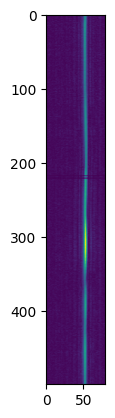

In [31]:
plt.imshow(data[:,:,10])

In [36]:
enfaces = np.array(enfaces)

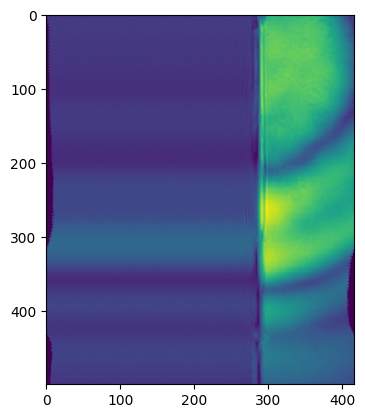

In [38]:
plt.imshow(enfaces[0])